In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

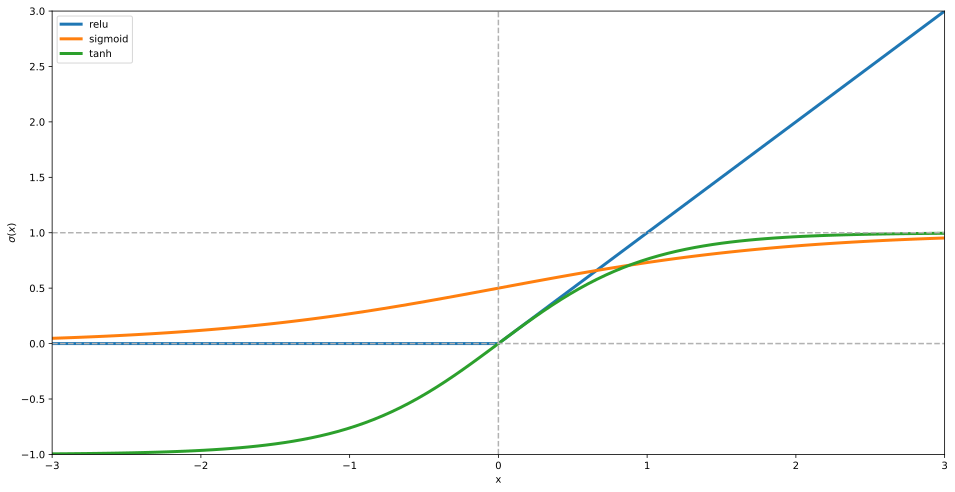

In [2]:
x = torch.linspace(-3, 3, 101)

def nn_output_functions(func):
    act_fun = getattr(torch, func)
    return act_fun(x)

activation_func = ['relu', 'sigmoid', 'tanh']

fig = plt.figure(figsize=(16, 8))

for fun in activation_func:
    plt.plot(x, nn_output_functions(fun), label=fun, linewidth=3)

dash_line_col = [0.7, 0.7, 0.7]
plt.plot(x[[0, -1]], [0, 0], '--', color=dash_line_col)
plt.plot(x[[0, -1]], [1, 1], '--', color=dash_line_col)
plt.plot([0, 0], [-1, 3], '--', color=dash_line_col)

plt.legend()
plt.xlabel('x')
plt.ylabel('$\sigma(x)$')
plt.xlim(x[[0, -1]])
plt.ylim([-1, 3]);

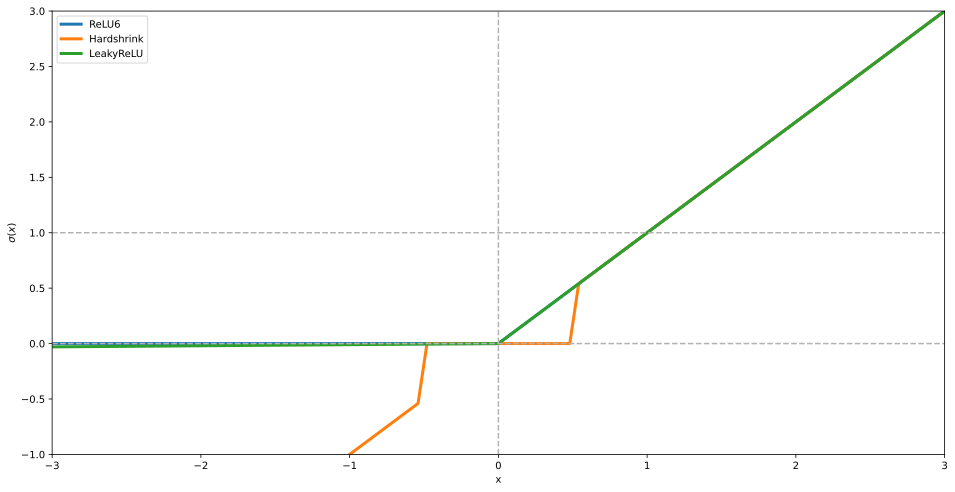

In [3]:
def nn_output_functions(func):
    act_fun = getattr(torch.nn, func)
    return act_fun()

activation_func = ['ReLU6', 'Hardshrink', 'LeakyReLU']

fig = plt.figure(figsize=(16, 8))

for fun in activation_func:
    plt.plot(x, nn_output_functions(fun)(x), label=fun, linewidth=3)

dash_line_col = [0.7, 0.7, 0.7]
plt.plot(x[[0, -1]], [0, 0], '--', color=dash_line_col)
plt.plot(x[[0, -1]], [1, 1], '--', color=dash_line_col)
plt.plot([0, 0], [-1, 3], '--', color=dash_line_col)

plt.legend()
plt.xlabel('x')
plt.ylabel('$\sigma(x)$')
plt.xlim(x[[0, -1]])
plt.ylim([-1, 3]);

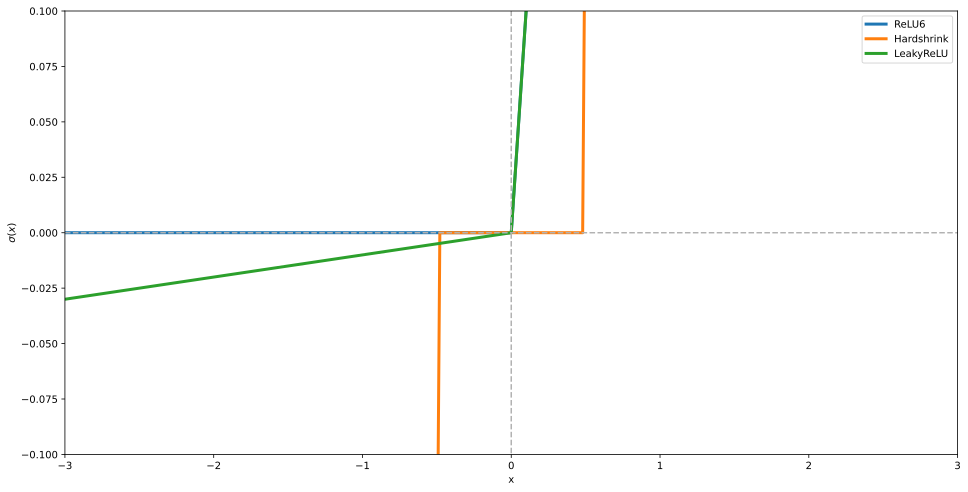

In [4]:
def nn_output_functions(func):
    act_fun = getattr(torch.nn, func)
    return act_fun()

activation_func = ['ReLU6', 'Hardshrink', 'LeakyReLU']

fig = plt.figure(figsize=(16, 8))

for fun in activation_func:
    plt.plot(x, nn_output_functions(fun)(x), label=fun, linewidth=3)

dash_line_col = [0.7, 0.7, 0.7]
plt.plot(x[[0, -1]], [0, 0], '--', color=dash_line_col)
plt.plot(x[[0, -1]], [1, 1], '--', color=dash_line_col)
plt.plot([0, 0], [-1, 3], '--', color=dash_line_col)

plt.legend()
plt.xlabel('x')
plt.ylabel('$\sigma(x)$')
plt.xlim(x[[0, -1]])
plt.ylim([-0.1, 0.1]);

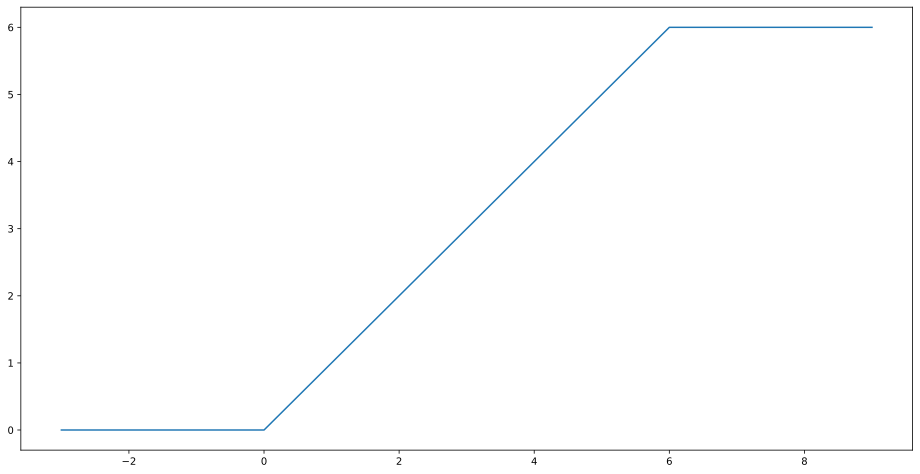

In [5]:
x = torch.linspace(-3, 9, 101)

relu6 = torch.nn.ReLU6()

plt.figure(figsize=(16, 8))

plt.plot(x, relu6(x));

In [6]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

In [7]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

wine_data = pd.read_csv(url, sep=';')

wine_data_normalize = wine_data.copy()
wine_data_normalize = wine_data_normalize[wine_data_normalize['total sulfur dioxide']<200]

col_zscore = wine_data_normalize.keys()
col_zscore = col_zscore.drop("quality")
wine_data_normalize[col_zscore] = wine_data_normalize[col_zscore].apply(stats.zscore)

wine_data_normalize["boolQuality"] = 0
wine_data_normalize["boolQuality"][wine_data_normalize["quality"]>5] = 1

C:\Users\drkum\AppData\Local\Temp\ipykernel_9412\18218786.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine_data_normalize["boolQuality"][wine_data_normalize["quality"]>5] = 1


In [8]:
data_tensor = torch.tensor(wine_data_normalize[col_zscore].values).float()
label_tensor = torch.tensor(data=wine_data_normalize["boolQuality"].values).float()
label_tensor = label_tensor[:, None]

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, label_tensor, test_size=0.1)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data, shuffle=True, drop_last=True, batch_size=128)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

# Compare the ReLU, Sigmoid, TanH

In [9]:
class wineClass(nn.Module):
    def __init__(self, act_func):
        super().__init__()

        self.input = nn.Linear(11, 16)

        self.hidden_1 = nn.Linear(16, 32)
        self.hidden_2 = nn.Linear(32, 20)

        self.output = nn.Linear(20, 1)
        
        self.act_func = act_func

    def forward(self, x):
        
        act_func = getattr(torch, self.act_func)
        x = self.input(x)
        x = act_func(x)
        
        x = self.hidden_1(x)
        x = act_func(x)

        x = self.hidden_2(x)
        x = act_func(x)
        
        return self.output(x)

In [10]:
num_epochs = 1500

def trainModel(annWine):

    loss_fun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(annWine.parameters(), lr=0.01)

    losses = torch.zeros(num_epochs)
    train_acc = []
    test_acc = []

    for epoch in range(num_epochs):

        annWine.train()

        batch_acc = []
        batch_loss = []

        for x, y in train_loader:
            y_hat = annWine(x)

            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())
            batch_acc.append(100*torch.mean(((y_hat > 0) == y).float()).item())

        train_acc.append(np.mean(batch_acc))
        losses[epoch] = np.mean(batch_loss)

        annWine.eval()
        x, y = next(iter(test_loader))
        with torch.no_grad():
            test_acc.append(100*torch.mean(((annWine(x) > 0) == y).float()).item())

    return train_acc, test_acc, losses

In [11]:
activation_func = ['relu', 'tanh', 'sigmoid']

trainAct = np.zeros((num_epochs, len(activation_func)))
testAct = np.zeros((num_epochs, len(activation_func)))

for i, act_fun in enumerate(activation_func):
    annWine = wineClass(act_fun)
    trainAct[:, i], testAct[:, i], _ = trainModel(annWine)

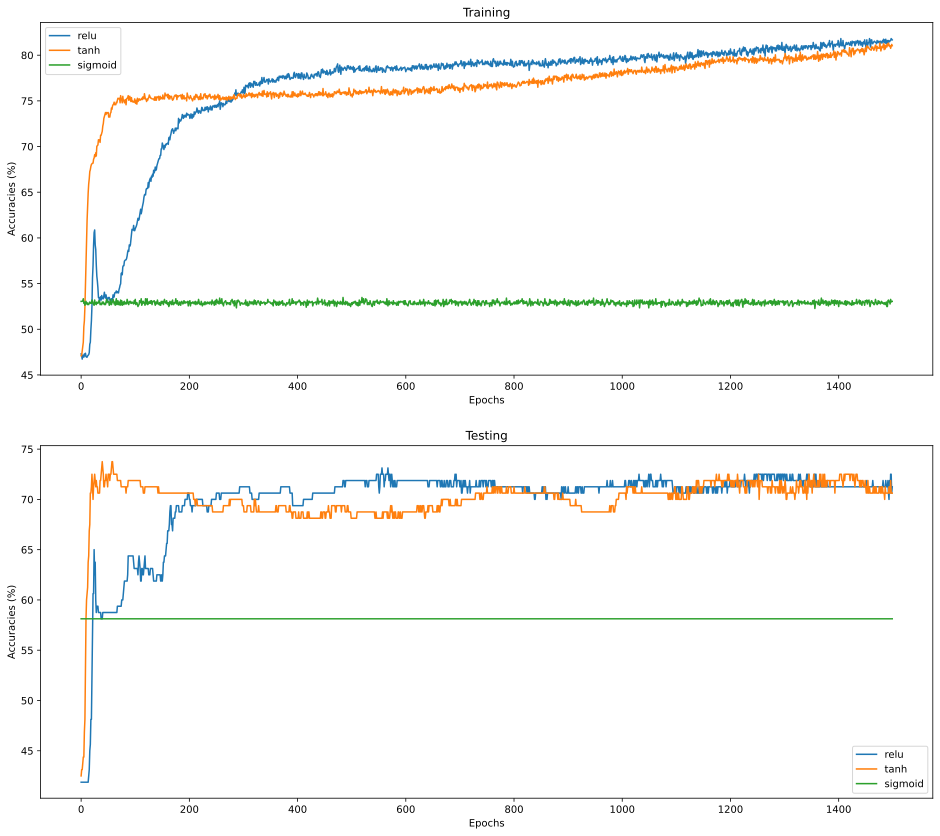

In [12]:
_, axis = plt.subplots(2, 1, figsize=(16, 14))
axis[0].plot(trainAct)
axis[0].set_ylabel("Accuracies (%)")
axis[0].set_xlabel("Epochs")
axis[0].set_title("Training")
axis[0].legend(activation_func)

axis[1].plot(testAct)
axis[1].set_ylabel("Accuracies (%)")
axis[1].set_xlabel("Epochs")
axis[1].set_title("Testing")
axis[1].legend(activation_func);

# Compare the ReLU, Leaky-ReLU, ReLU-N

In [13]:
class wineClass(nn.Module):
    def __init__(self, act_func):
        super().__init__()

        self.input = nn.Linear(11, 16)

        self.hidden_1 = nn.Linear(16, 32)
        self.hidden_2 = nn.Linear(32, 20)

        self.output = nn.Linear(20, 1)

        self.act_func = act_func

    def forward(self, x):

        act_func = getattr(torch.nn, self.act_func)
        x = self.input(x)
        x = act_func()(x)

        x = self.hidden_1(x)
        x = act_func()(x)

        x = self.hidden_2(x)
        x = act_func()(x)

        return self.output(x)

In [14]:
activation_func = ['ReLU6', 'LeakyReLU', 'ReLU']

trainAct = np.zeros((num_epochs, len(activation_func)))
testAct = np.zeros((num_epochs, len(activation_func)))

for i, act_fun in enumerate(activation_func):
    annWine = wineClass(act_fun)
    trainAct[:, i], testAct[:, i], _ = trainModel(annWine)

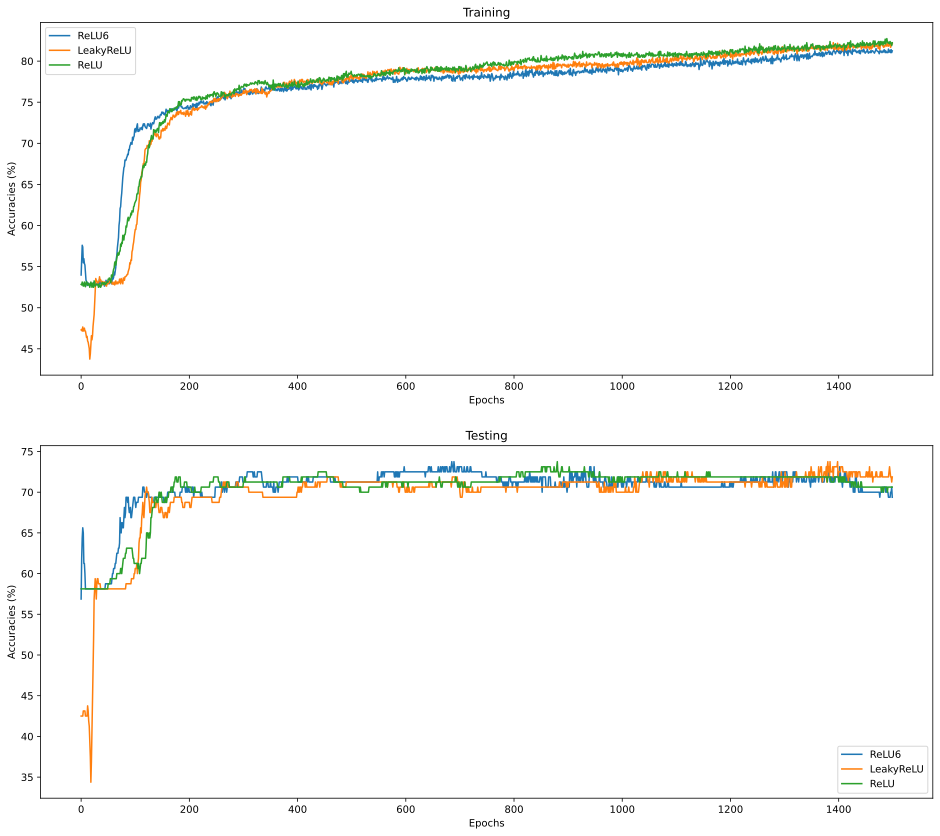

In [15]:
_, axis = plt.subplots(2, 1, figsize=(16, 14))
axis[0].plot(trainAct)
axis[0].set_ylabel("Accuracies (%)")
axis[0].set_xlabel("Epochs")
axis[0].set_title("Training")
axis[0].legend(activation_func)

axis[1].plot(testAct)
axis[1].set_ylabel("Accuracies (%)")
axis[1].set_xlabel("Epochs")
axis[1].set_title("Testing")
axis[1].legend(activation_func);

# Predict Residual Sugar from Wine Dataset

In [16]:
wine_data_normalize = wine_data.copy()
wine_data_normalize = wine_data_normalize[wine_data_normalize['total sulfur dioxide']<200]

col_zscore = wine_data_normalize.keys()
wine_data_normalize[col_zscore] = wine_data_normalize[col_zscore].apply(stats.zscore)

In [17]:
col_zscore = col_zscore.drop('residual sugar')

data_tensor = torch.tensor(wine_data_normalize[col_zscore].values).float()
label_tensor = torch.tensor(data=wine_data_normalize["residual sugar"].values).float()
label_tensor = label_tensor[:, None]

train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(data_tensor, label_tensor, test_size=0.1)

train_data = TensorDataset(train_data_split, train_labels_split)
test_data = TensorDataset(test_data_split, test_labels_split)

train_loader = DataLoader(train_data, shuffle=True, drop_last=True, batch_size=64)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [18]:
class wineClass(nn.Module):
    def __init__(self, act_func):
        super().__init__()

        self.input = nn.Linear(11, 16)

        self.hidden_1 = nn.Linear(16, 32)
        self.hidden_2 = nn.Linear(32, 20)

        self.output = nn.Linear(20, 1)

        self.act_func = act_func

    def forward(self, x):

        act_func = getattr(torch, self.act_func)
        x = self.input(x)
        x = act_func(x)

        x = self.hidden_1(x)
        x = act_func(x)

        x = self.hidden_2(x)
        x = act_func(x)

        return self.output(x)

In [19]:
num_epochs = 1500

def trainModel(annWine):

    loss_fun = nn.MSELoss()
    optimizer = torch.optim.SGD(annWine.parameters(), lr=0.01)

    train_loss = torch.zeros(num_epochs)
    test_loss = torch.zeros(num_epochs)

    for epoch in range(num_epochs):

        annWine.train()

        batch_loss = []

        for x, y in train_loader:
            y_hat = annWine(x)

            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())

        train_loss[epoch] = np.mean(batch_loss)

        annWine.eval()
        x, y = next(iter(test_loader))
        with torch.no_grad():
            test_loss[epoch] = loss_fun(annWine(x), y).item()

    return train_loss, test_loss

In [20]:
annWine = wineClass('relu')
train_loss, test_loss = trainModel(annWine)

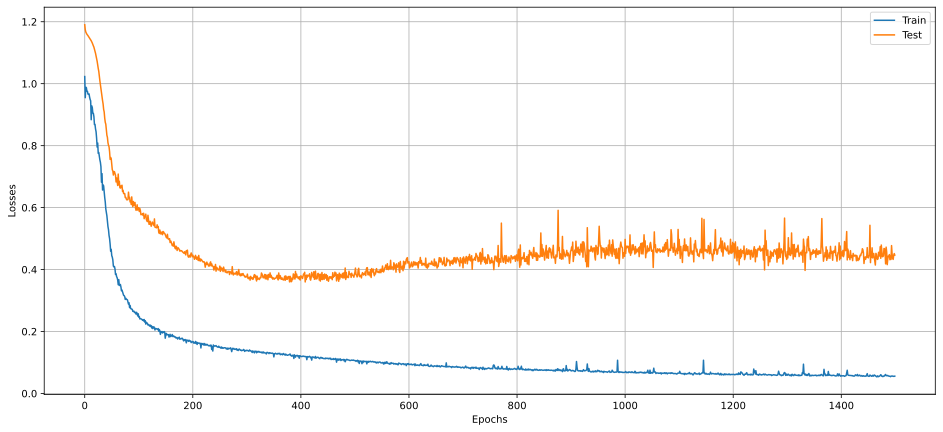

In [21]:
plt.figure(figsize=(16, 7))
plt.plot(train_loss)
plt.plot(test_loss)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend(["Train", "Test"])
plt.grid();

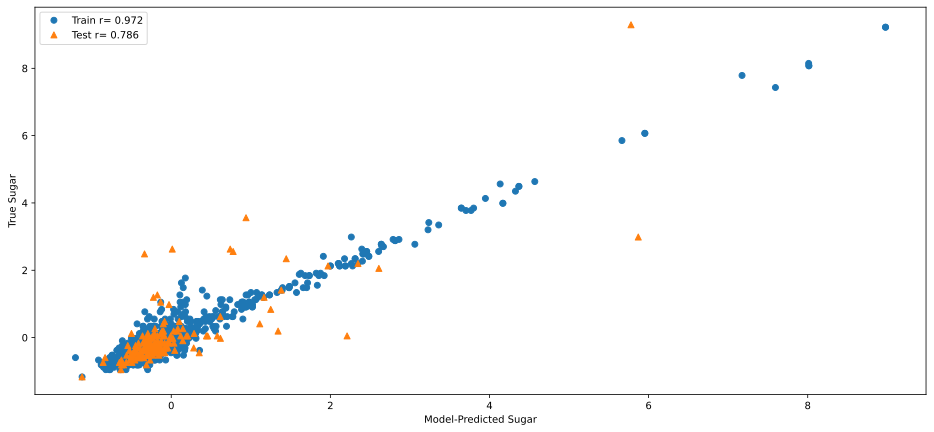

In [22]:
plt.figure(figsize=(16, 7))
plt.plot(annWine(train_data_split).detach(), train_labels_split, 'o')
plt.plot(annWine(test_data_split).detach(), test_labels_split, '^')
plt.xlabel("Model-Predicted Sugar")
plt.ylabel("True Sugar")

corr_train = np.corrcoef(annWine(train_data_split).detach().T, train_labels_split.T)[1, 0]
corr_test = np.corrcoef(annWine(test_data_split).detach().T, test_labels_split.T)[1, 0]

plt.legend([f"Train r={corr_train: 0.3f}", f"Test r={corr_test: 0.3f}"]);

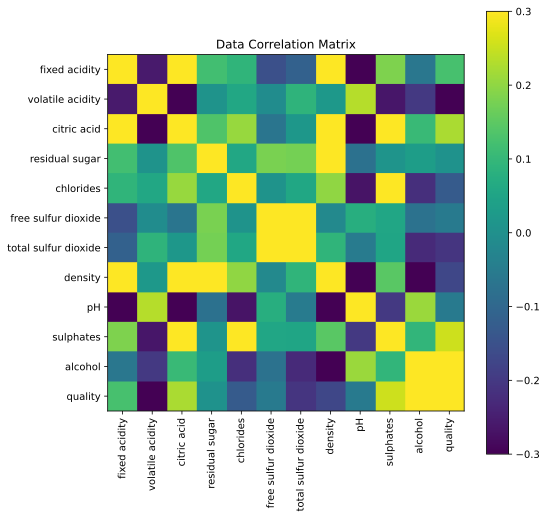

In [23]:
plt.figure(figsize=(8, 8))
plt.imshow(np.corrcoef(wine_data_normalize.T), vmin=-0.3, vmax=0.3)
plt.xticks(range(len(wine_data_normalize.keys())), labels=wine_data_normalize.keys(), rotation=90)
plt.yticks(range(len(wine_data_normalize.keys())), labels=wine_data_normalize.keys())
plt.colorbar()
plt.title("Data Correlation Matrix");